# Diffusion Visualisation

This notebook is used to visualise and test the guided diffusion pipelines.

## Unguided Generation

In [29]:
import os
import numpy as np
from omegaconf import OmegaConf
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from guided_diffusion.script_util import create_classifier, classifier_defaults
from rware.warehouse import Warehouse

from diffusion_co_design.pretrain.rware.transform import (
    storage_to_layout,
)
from diffusion_co_design.pretrain.rware.generate import (
    generate,
    WarehouseRandomGeneratorConfig,
)
from diffusion_co_design.pretrain.rware.generator import (
    Generator,
    OptimizerDetails,
)
from diffusion_co_design.utils import (
    OUTPUT_DIR,
    get_latest_model,
    omega_to_pydantic,
    cuda as device,
)

REPRESENTATION = "graph"
SCENARIO_NAME = "rware_16_50_5_4_corners"

scenario: WarehouseRandomGeneratorConfig = omega_to_pydantic(
    OmegaConf.load(f"../diffusion_co_design/bin/conf/scenario/{SCENARIO_NAME}.yaml"),
    WarehouseRandomGeneratorConfig,
)
scenario.representation = REPRESENTATION

pretrain_dir = os.path.join(
    OUTPUT_DIR, f"diffusion_pretrain/{REPRESENTATION}", scenario.name
)
# generator_model_path = get_latest_model(pretrain_dir, "model")
generator_model_path = "/home/markhaoxiang/.diffusion_co_design/diffusion_pretrain/graph/rware_16_50_5_4_corners/model500000.pt"

print(f"Loading {generator_model_path}")


def show_batch(environment_batch, debug: bool = False):
    layouts = []
    for features in environment_batch:
        layout = storage_to_layout(features, config=scenario)
        warehouse = Warehouse(layout=layout, render_mode="rgb_array")

        if debug:
            print(warehouse.layout.storage.sum(axis=(1, 2)))

        layouts.append(warehouse.render())
        warehouse.close()

    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs = axs.ravel()
    for i in range(9):
        axs[i].imshow(layouts[i])
        axs[i].axis("off")
    return fig, axs

Loading /home/markhaoxiang/.diffusion_co_design/diffusion_pretrain/graph/rware_16_50_5_4_corners/model500000.pt


In [30]:
generator_args = {
    "generator_model_path": generator_model_path,
    "scenario": scenario,
    "representation": scenario.representation,
    "batch_size": 9,
}

generator = Generator(**generator_args)


[13. 13. 10. 10.]
[13. 12. 12. 11.]
[13. 12. 11. 11.]
[13. 13.  9. 12.]
[13. 13. 10. 10.]
[12. 11. 10. 10.]
[12. 11. 10. 11.]
[13. 11. 11. 10.]
[13. 11. 11. 12.]


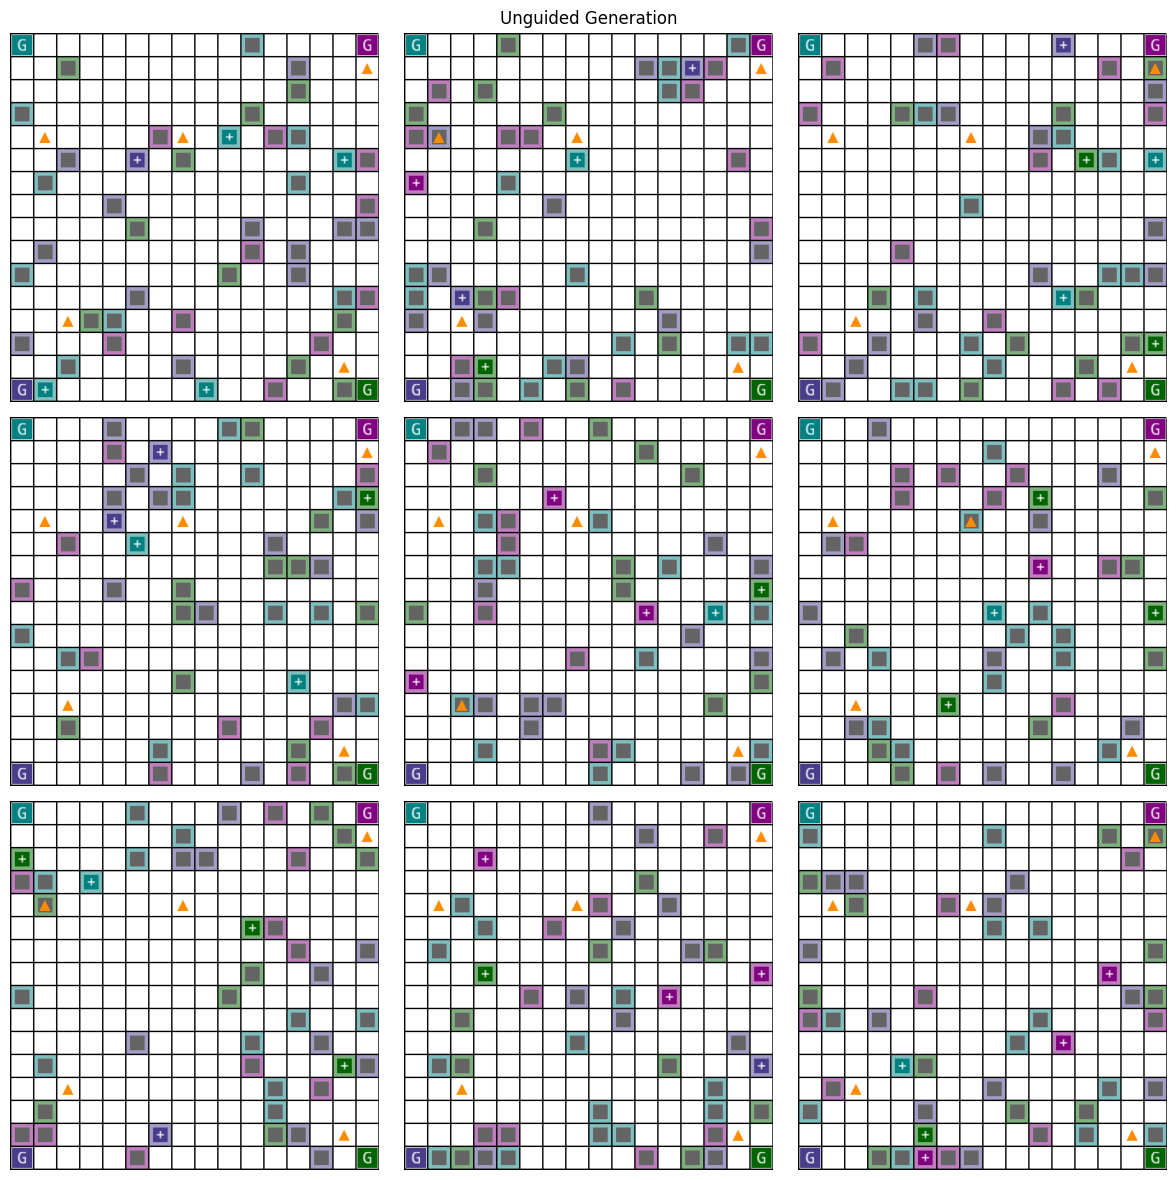

In [31]:
environment_batch = generator.generate_batch()
fig, axs = show_batch(environment_batch, debug=True)
fig.suptitle("Unguided Generation")
fig.tight_layout()

5.0


np.float64(0.10537900775671005)

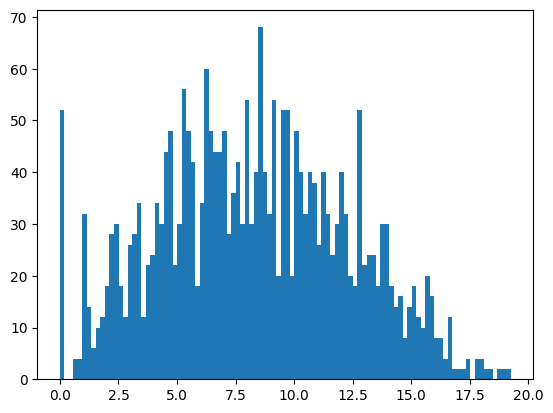

In [22]:
env = environment_batch[7]
dists = np.sqrt(((env[None, :] - env[:, None]) ** 2).sum(axis=-1))
plt.hist(dists.flatten(), bins=100)
pass

print(((dists < 1).sum() - scenario.n_shelves) / 2)

(dists + np.eye(scenario.n_shelves)).min()

In [ ]:
generator_args = {
    "generator_model_path": generator_model_path,
    "scenario": scenario,
    "representation": scenario.representation,
    "batch_size": 9,
}

generator = Generator(**generator_args)
environment_batch = generator.generate_batch()
fig, axs = show_batch(environment_batch, debug=True)
fig.suptitle("Unguided Generation")
fig.tight_layout()

In [ ]:
# Co-variance Test

NUM_TEST_IMAGES = 1000

layouts = []
cfg = generator_args.copy()
cfg["batch_size"] = 20
generator = Generator(**cfg)
with tqdm(total=NUM_TEST_IMAGES) as pbar:
    while len(layouts) < NUM_TEST_IMAGES:
        environment_batch = generator.generate_batch()
        for features in environment_batch:
            layout = storage_to_layout(
                features, scenario.agent_idxs, scenario.goal_idxs, scenario.goal_colors
            )
            layouts.append(layout)
            pbar.update()
layouts_1 = np.stack([l.highways.flatten() for l in layouts])


layouts = []
with tqdm(total=NUM_TEST_IMAGES) as pbar:
    while len(layouts) < NUM_TEST_IMAGES:
        layout = storage_to_layout(
            generate(
                size=16,
                n_shelves=50,
                agent_idxs=scenario.agent_idxs,
                goal_idxs=scenario.goal_idxs,
                n_colors=scenario.n_colors,
                n=1,
            )[0],
            scenario.agent_idxs,
            scenario.goal_idxs,
            scenario.goal_colors,
        )
        layouts.append(layout)
        pbar.update()
layouts_2 = np.stack([l.highways.flatten() for l in layouts])

In [ ]:
fig, axs = plt.subplots(2)
axs[0].set_yscale("log")
axs[0].set_title("Diffusion Generated")
axs[0].hist(np.cov(layouts_1).flatten(), bins=50)
axs[1].set_title("Randomly Generated")
axs[1].set_yscale("log")
axs[1].hist(np.cov(layouts_2).flatten(), bins=50)
fig.set_constrained_layout(True)
pass

In [ ]:
GUIDANCE_WT = 10
TRAIN_NUM_ITERATIONS = 20
TRAIN_BATCH_SIZE = 128
VALUE_LR = 3e-4
VALUE_WEIGHT_DECAY = 0.05
RECOMPUTE = True
# RECOMPUTE = False

# Build pseudo value function
generator = Generator(**cfg, guidance_wt=GUIDANCE_WT)

X = generate(
    size=scenario.size,
    n_shelves=scenario.n_shelves,
    agent_idxs=scenario.agent_idxs,
    goal_idxs=scenario.goal_idxs,
    n_colors=scenario.n_colors,
    n=50_000,
)
X = torch.tensor(X)
y = []

U = np.zeros((16, 16), dtype=int)
U[4:13, 4] = 1
U[5:13, 3] = 1
U[12, 4:13] = 1
U[13, 4:13] = 1
U[4:13, 12] = 1
U[5:13, 13] = 1
U_map = torch.from_numpy(U).unsqueeze(0).to(device=device, dtype=torch.float32)
for x in X:
    layout = storage_to_layout(
        x, scenario.agent_idxs, scenario.goal_idxs, scenario.goal_colors
    )

    # To one side
    # y.append(sum([s.x for s in layout.reset_shelves()]))

    # Draw a U
    v = 0
    for s in layout.reset_shelves():
        v += U[*s.pos]
    y.append(v)

y = torch.tensor(y).to(device)
# y = y - y.min() + 1
# y = y / y.mean(dtype=torch.float32)
# X = X.movedim(-1, -3).to(device)
X = X.to(device)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE)

In [ ]:
# Create value model
model_dict = classifier_defaults()
model_dict["image_size"] = scenario.size
model_dict["image_channels"] = scenario.n_colors
model_dict["classifier_width"] = 256
model_dict["classifier_depth"] = 2
model_dict["classifier_attention_resolutions"] = "16, 8, 4"
model_dict["output_dim"] = 1

model = create_classifier(**model_dict).to(device)

# Train
optim = torch.optim.Adam(
    model.parameters(), lr=VALUE_LR, weight_decay=VALUE_WEIGHT_DECAY
)
criterion = torch.nn.MSELoss()

if RECOMPUTE:
    model.train()
    losses = []
    with tqdm(range(TRAIN_NUM_ITERATIONS)) as pbar:
        for epoch in pbar:
            running_loss = 0.0
            for X_batch, y_batch in dataloader:
                optim.zero_grad()

                X_batch = X_batch.to(torch.float32)
                # X_batch = torch.cat(
                # [X_batch, U_map.expand(X_batch.shape[0], -1, -1, -1)], dim=1
                # )
                X_batch = (X_batch * 2) - 1
                y_batch = y_batch.to(torch.float32)
                # t, _ = generator.schedule_sampler.sample(len(X_batch), device)
                # X_batch = generator.diffusion.q_sample(X_batch, t)

                # y_pred = model(X_batch, t).squeeze()
                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                running_loss += loss.item()
                loss.backward()
                optim.step()
            running_loss = running_loss / len(dataloader)
            pbar.set_description(f"Epoch {epoch} | Loss {running_loss}")
            losses.append(running_loss)
    torch.save(model.state_dict(), "diffusion_visualisation_classifier.pt")
else:
    model.load_state_dict(torch.load("diffusion_visualisation_classifier.pt"))

In [ ]:
plt.plot(losses)
plt.yscale("log")

In [ ]:
plt.imshow(U)

In [ ]:
generator = Generator(**generator_args, guidance_wt=1000)
model.eval()
operation = OptimizerDetails()
operation.num_recurrences = 8
operation.backward_steps = 0
# operation.operated_image = (U_map + 1) / 2
environment_batch = generator.generate_batch(
    value=model, use_operation=True, operation_override=operation
)
# environment_batch = generator.generate_batch(value=model)
for env in environment_batch:
    layout = storage_to_layout(
        env, scenario.agent_idxs, scenario.goal_idxs, scenario.goal_colors
    )
    print(len(layout.reset_shelves()))
fig, axs = show_batch(environment_batch)
fig.suptitle("Guided Generation")
fig.tight_layout()

# Note: Guidance weights need to be set really high for any decent signal?